# Check out Markets (morning session)

In [1]:
import pandas as pd
import yfinance as yf
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')
def get_premarket_changes(tickers):
    # Dictionary to store pre-market data for each stock
    premarket_data = {}

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        # Fetching pre-market price (current price in pre-market)
        premarket_price = stock.history(period="1d", prepost=True)["Close"].iloc[-1]

        # Fetching last close price
        last_close_price = stock.history(period="1d", prepost=False)["Close"].iloc[-1]

        # Calculating percentage change
        change_percentage = ((premarket_price - last_close_price) / last_close_price) * 100

        # Storing data
        premarket_data[ticker] = {
            'Last Close Price': round(last_close_price,2),
            'Pre-market Price': round(premarket_price,2),
            'Change (%)': round(change_percentage, 2)
        }

    return premarket_data


# Example usage
tickers = ['NVDA', 'AAPL', 'BTC-USD', 'BABA', 'OWL', 'GGAL', 'MSFT', 'PDD','SPY', 'GLD']
premarket_changes = get_premarket_changes(tickers)

# Convert to DataFrame
df = pd.DataFrame(premarket_changes).T

# Function to apply color based on the change percentage
def color_change(val):
    color = 'red' if val < 0 else 'green' if val > 0 else ''
    return f'color: {color};'

# Apply styling
df_styled = df.style.applymap(color_change, subset=['Change (%)'])\
    .format("{:.2f}", subset=['Last Close Price', 'Pre-market Price', 'Change (%)'])

# To display the styled DataFrame in a Jupyter Notebook environment, you can just use:
df_styled



,Last Close Price,Pre-market Price,Change (%)
NVDA,121.40,121.40,0.00
AAPL,227.79,227.79,0.00
BTC-USD,65833.08,65833.08,0.00
BABA,107.33,107.33,0.00
OWL,19.24,19.24,0.00
GGAL,43.78,43.78,0.00
MSFT,428.02,428.02,0.00
PDD,135.38,135.38,0.00
SPY,571.47,571.47,0.00
GLD,245.02,245.02,0.00


# Yield Spread Analysis

This notebook provides an analysis of the yield spread between 2-year and 10-year US Treasury bonds. The yield spread is a key economic indicator that can help identify the current state of the economy and predict future economic conditions.

## Objective

The objective of this analysis is to:
1. Calculate the yield spread between 2-year and 10-year Treasury bonds.
2. Analyze the weekly trends over the last 10 weeks.
3. Visualize the changes in the spread and highlight trends in the data.

### Yield story

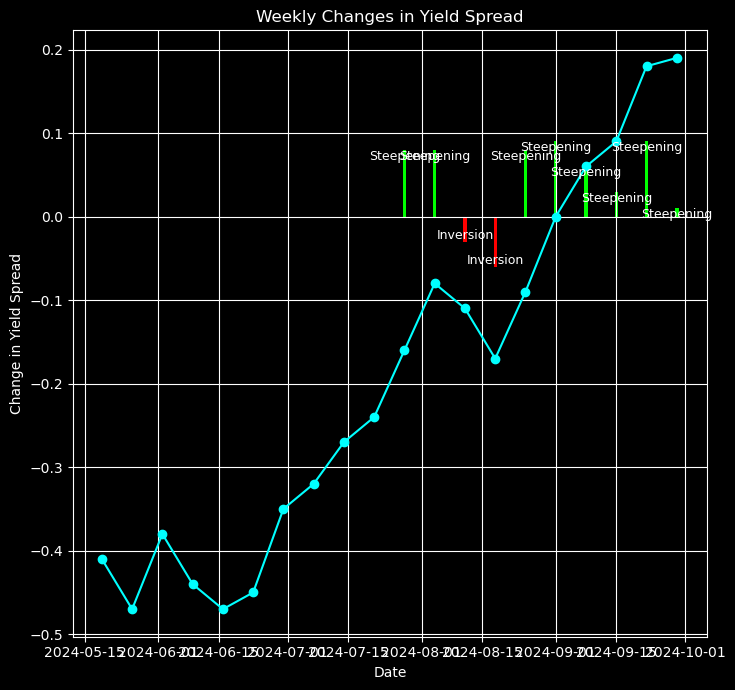

,Date,Yield Spread,Weekly Change,Trend
0,2024-07-28,-0.160000,0.080000,Positive
1,2024-08-04,-0.080000,0.080000,Positive
2,2024-08-11,-0.110000,-0.030000,Negative
3,2024-08-18,-0.170000,-0.060000,Negative
4,2024-08-25,-0.090000,0.080000,Positive
5,2024-09-01,0.000000,0.090000,Positive
6,2024-09-08,0.060000,0.060000,Positive
7,2024-09-15,0.090000,0.030000,Positive
8,2024-09-22,0.180000,0.090000,Positive
9,2024-09-29,0.190000,0.010000,Positive


In [13]:
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set the date range for the data
start = datetime.now() - pd.DateOffset(weeks=20)  # Extra weeks to ensure full data for 10 weeks
end = datetime.now()

# Fetch the 2-year and 10-year Treasury rates
rates_2yr = web.DataReader('DGS2', 'fred', start, end)
rates_10yr = web.DataReader('DGS10', 'fred', start, end)

# Calculate the spread between 10-year and 2-year yields and resample weekly
spread = rates_10yr['DGS10'] - rates_2yr['DGS2']
spread_weekly = spread.resample('W').last()

# Calculate weekly changes
spread_change = spread_weekly.diff().tail(10)

# Preparing the data for display
spread_display = pd.DataFrame({
    'Date': spread_change.index.date,
    'Yield Spread': spread_weekly.tail(10).values,
    'Weekly Change': spread_change.values
})
spread_display['Trend'] = ['Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral' for x in spread_change]

# Function to apply color based on the condition, handling non-numeric values correctly
def color_negative_red_positive_green(val):
    try:
        if pd.isnull(val):
            return ''  # No style if value is NaN
        elif val < 0:
            return 'background-color: red'
        elif val > 0:
            return 'background-color: green'
    except TypeError:
        return ''

# Using a dark background for plots
plt.style.use('dark_background')
plt.figure(figsize=(14, 7))

# First subplot for line graph
plt.subplot(1, 2, 1)
plt.plot(spread_weekly.index, spread_weekly, marker='o', linestyle='-', color='cyan')
plt.title('2-10 Year Treasury Yield Spread Over Time')
plt.ylabel('Yield Spread (percentage points)')
plt.xlabel('Date')
plt.grid(True)

# Second subplot for bar chart
colors = ['red' if x < 0 else 'lime' for x in spread_change]
bars = plt.bar(spread_change.index, spread_change, color=colors)
plt.title('Weekly Changes in Yield Spread')
plt.ylabel('Change in Yield Spread')
plt.xlabel('Date')

# Annotate bars with "Inversion" or "Steepening"
for bar in bars:
    height = bar.get_height()
    label = 'Inversion' if height < 0 else 'Steepening'
    plt.text(bar.get_x() + bar.get_width() / 2, height, label,
             ha='center', va='bottom' if height < 0 else 'top', color='white', fontsize=9)

plt.tight_layout()
plt.show()

# Display styled DataFrame
styled_df = spread_display.style.applymap(color_negative_red_positive_green, subset=['Weekly Change', 'Trend'])
styled_df

